In [1]:
# 필요한 라이브러리 및 모듈 불러오기
import os
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import sys
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sys.path.append(r"C:\Users\dhshs\Documents\ganomaly_global")
sys.path.append(r"C:\Users\dhshs\Documents\ganomaly_global\lib")
from lib.model import Ganomaly  # lib/model.py에서 제공되는 GANomaly 모델 사용
from lib.evaluate import evaluate, roc  # evaluate.py에서 제공되는 평가 함수 사용
from lib.visualizer import Visualizer  # visualizer.py에서 제공되는 시각화 클래스 사용
from options import Options  # 옵션 파일

# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
# 컬러
class CustomDataset(Dataset): 
    def __init__(self, directory, label, transform=None):
        self.directory = directory
        self.transform = transform
        self.label = label  # 레이블 정보 추가
        self.images = [img for img in os.listdir(directory) if img.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.directory, self.images[idx])
        image = Image.open(img_path)  # 컬러 이미지로 로드

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(self.label, dtype=torch.long)  # 레이블 포함하여 반환

In [3]:
# 데이터셋 경로 설정
normal_train_dir = r"C:\Users\dhshs\Documents\ganomaly_global\dataset\CIFAR\train\0.normal"
abnormal_test_dir = r"C:\Users\dhshs\Documents\ganomaly_global\dataset\CIFAR\test\1.abnormal"
normal_test_dir = r"C:\Users\dhshs\Documents\ganomaly_global\dataset\CIFAR\test\0.normal"

# 데이터 전처리 및 데이터 로더 설정
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # 이미지 크기 조정
    transforms.ToTensor(),  # 텐서로 변환
])

# 학습 및 테스트 데이터셋 생성
train_dataset = CustomDataset(normal_train_dir, label=0, transform=transform)  # 학습 데이터셋 로드 (normal만)
normal_test_dataset = CustomDataset(normal_test_dir, label=0, transform=transform)  # 테스트 데이터셋 로드 (normal)
abnormal_test_dataset = CustomDataset(abnormal_test_dir, label=1, transform=transform)  # 테스트 데이터셋 로드 (abnormal)

# 두 개의 테스트 데이터셋을 합침
from torch.utils.data import ConcatDataset

test_dataset = ConcatDataset([normal_test_dataset, abnormal_test_dataset])

# 데이터 로더 설정
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)


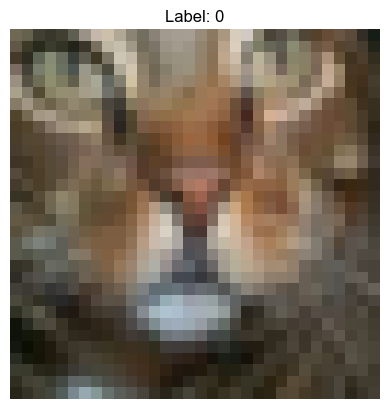

In [4]:
# 컬러
import matplotlib.pyplot as plt
import matplotlib as mpl

# LaTeX 비활성화
mpl.rcParams['text.usetex'] = False

# 데이터 로더에서 샘플 하나 가져오기
sample_image, sample_label = next(iter(test_loader))  # 첫 배치에서 이미지와 레이블 가져오기
image = sample_image[0]  # 첫 번째 이미지 선택

# 텐서를 NumPy로 변환 및 채널 순서 변경 (C, H, W -> H, W, C)
image_np = image.permute(1, 2, 0).numpy()

# 시각화
plt.rcParams["font.family"] = "Arial"
plt.imshow(image_np)
plt.title(f"Label: {sample_label[0].item()}")
plt.axis('off')
plt.show()


In [5]:
# Jupyter Notebook의 매개변수를 무시하도록 설정
sys.argv = ['']

# 옵션 설정
opt = Options().parse()
opt.isize = 32  # 데이터의 이미지 크기
opt.batchsize = 32  # 배치 크기 설정
opt.save_test_images = True  # 테스트 이미지 저장 설정
opt.display = True  # 실시간 시각화 설정
opt.use_context_pred = True # 마스킹 설정

opt.outf = './output(CIFAR with mask)'
opt.nz = 500    # 잠재 벡터 차원 수 
opt.nc = 3       # 채널 수
opt.niter = 50 # 에폭 수
opt.context_mask_size = 8 # 마스킹 블록 크기

In [6]:
dataloader = {'train': train_loader, 'test': test_loader}  # 데이터 로더 설정

# GANomaly 모델 생성
model = Ganomaly(opt, dataloader)

Setting up a new session...


In [7]:
model.train()

>> Training model Ganomaly.


Epoch [1/50], Generator Loss: 11.0721, Discriminator Loss: 0.0357
Epoch [1/50] - Avg Generator Loss: 11.0721, Avg Discriminator Loss: 0.0357, Best AUC: 0.5298
   Avg Run Time (ms/batch): 3.969 roc: 0.530 max roc: 0.530


Epoch [2/50], Generator Loss: 6.2440, Discriminator Loss: 0.0146
Epoch [2/50] - Avg Generator Loss: 6.2440, Avg Discriminator Loss: 0.0146, Best AUC: 0.5298
   Avg Run Time (ms/batch): 3.218 roc: 0.525 max roc: 0.530


Epoch [3/50], Generator Loss: 5.5059, Discriminator Loss: 0.0555
Epoch [3/50] - Avg Generator Loss: 5.5059, Avg Discriminator Loss: 0.0555, Best AUC: 0.5412
   Avg Run Time (ms/batch): 4.156 roc: 0.541 max roc: 0.541


Epoch [4/50], Generator Loss: 5.1017, Discriminator Loss: 0.0149
Epoch [4/50] - Avg Generator Loss: 5.1017, Avg Discriminator Loss: 0.0149, Best AUC: 0.5412
   Avg Run Time (ms/batch): 3.352 roc: 0.531 max roc: 0.541


Epoch [5/50], Generator Loss: 4.8948, Discriminator Loss: 0.0077
Epoch [5/50] - Avg Generator Loss: 4.8948, Avg Discriminator Loss: 0.0077, Best AUC: 0.5505
   Avg Run Time (ms/batch): 3.668 roc: 0.550 max roc: 0.550


Epoch [6/50], Generator Loss: 4.6844, Discriminator Loss: 0.0100
Epoch [6/50] - Avg Generator Loss: 4.6844, Avg Discriminator Loss: 0.0100, Best AUC: 0.5683
   Avg Run Time (ms/batch): 3.448 roc: 0.568 max roc: 0.568


Epoch [7/50], Generator Loss: 4.5453, Discriminator Loss: 0.0045
Epoch [7/50] - Avg Generator Loss: 4.5453, Avg Discriminator Loss: 0.0045, Best AUC: 0.5683
   Avg Run Time (ms/batch): 6.445 roc: 0.560 max roc: 0.568


Epoch [8/50], Generator Loss: 4.3971, Discriminator Loss: 0.0056
Epoch [8/50] - Avg Generator Loss: 4.3971, Avg Discriminator Loss: 0.0056, Best AUC: 0.5683
   Avg Run Time (ms/batch): 3.464 roc: 0.566 max roc: 0.568


Epoch [9/50], Generator Loss: 4.3235, Discriminator Loss: 0.0039
Epoch [9/50] - Avg Generator Loss: 4.3235, Avg Discriminator Loss: 0.0039, Best AUC: 0.5729
   Avg Run Time (ms/batch): 3.311 roc: 0.573 max roc: 0.573


Epoch [10/50], Generator Loss: 4.1329, Discriminator Loss: 0.3757
Epoch [10/50] - Avg Generator Loss: 4.1329, Avg Discriminator Loss: 0.3757, Best AUC: 0.5806
   Avg Run Time (ms/batch): 4.572 roc: 0.581 max roc: 0.581


Epoch [11/50], Generator Loss: 4.0134, Discriminator Loss: 0.0126
Epoch [11/50] - Avg Generator Loss: 4.0134, Avg Discriminator Loss: 0.0126, Best AUC: 0.5806
   Avg Run Time (ms/batch): 3.663 roc: 0.577 max roc: 0.581


Epoch [12/50], Generator Loss: 3.9754, Discriminator Loss: 0.0533
Epoch [12/50] - Avg Generator Loss: 3.9754, Avg Discriminator Loss: 0.0533, Best AUC: 0.5806
   Avg Run Time (ms/batch): 3.671 roc: 0.579 max roc: 0.581


Epoch [13/50], Generator Loss: 3.8753, Discriminator Loss: 0.0058
Epoch [13/50] - Avg Generator Loss: 3.8753, Avg Discriminator Loss: 0.0058, Best AUC: 0.5806
   Avg Run Time (ms/batch): 3.429 roc: 0.572 max roc: 0.581


Epoch [14/50], Generator Loss: 3.8083, Discriminator Loss: 0.0047
Epoch [14/50] - Avg Generator Loss: 3.8083, Avg Discriminator Loss: 0.0047, Best AUC: 0.5806
   Avg Run Time (ms/batch): 4.174 roc: 0.563 max roc: 0.581


Epoch [15/50], Generator Loss: 3.7576, Discriminator Loss: 0.0192
Epoch [15/50] - Avg Generator Loss: 3.7576, Avg Discriminator Loss: 0.0192, Best AUC: 0.5806
   Avg Run Time (ms/batch): 3.116 roc: 0.567 max roc: 0.581


Epoch [16/50], Generator Loss: 3.7381, Discriminator Loss: 0.0129
Epoch [16/50] - Avg Generator Loss: 3.7381, Avg Discriminator Loss: 0.0129, Best AUC: 0.5806
   Avg Run Time (ms/batch): 3.478 roc: 0.557 max roc: 0.581


Epoch [17/50], Generator Loss: 3.6882, Discriminator Loss: 0.0058
Epoch [17/50] - Avg Generator Loss: 3.6882, Avg Discriminator Loss: 0.0058, Best AUC: 0.5806
   Avg Run Time (ms/batch): 6.360 roc: 0.559 max roc: 0.581


Epoch [18/50], Generator Loss: 3.6729, Discriminator Loss: 0.0067
Epoch [18/50] - Avg Generator Loss: 3.6729, Avg Discriminator Loss: 0.0067, Best AUC: 0.5806
   Avg Run Time (ms/batch): 3.443 roc: 0.572 max roc: 0.581


Epoch [19/50], Generator Loss: 3.5834, Discriminator Loss: 0.0033
Epoch [19/50] - Avg Generator Loss: 3.5834, Avg Discriminator Loss: 0.0033, Best AUC: 0.5806
   Avg Run Time (ms/batch): 3.678 roc: 0.556 max roc: 0.581


Epoch [20/50], Generator Loss: 3.4694, Discriminator Loss: 0.1524
Epoch [20/50] - Avg Generator Loss: 3.4694, Avg Discriminator Loss: 0.1524, Best AUC: 0.5806
   Avg Run Time (ms/batch): 3.672 roc: 0.561 max roc: 0.581


Epoch [21/50], Generator Loss: 3.4763, Discriminator Loss: 0.0066
Epoch [21/50] - Avg Generator Loss: 3.4763, Avg Discriminator Loss: 0.0066, Best AUC: 0.5806
   Avg Run Time (ms/batch): 7.018 roc: 0.566 max roc: 0.581


Epoch [22/50], Generator Loss: 3.4791, Discriminator Loss: 0.0061
Epoch [22/50] - Avg Generator Loss: 3.4791, Avg Discriminator Loss: 0.0061, Best AUC: 0.5806
   Avg Run Time (ms/batch): 6.555 roc: 0.562 max roc: 0.581


Epoch [23/50], Generator Loss: 3.4092, Discriminator Loss: 0.0104
Epoch [23/50] - Avg Generator Loss: 3.4092, Avg Discriminator Loss: 0.0104, Best AUC: 0.5806
   Avg Run Time (ms/batch): 6.511 roc: 0.561 max roc: 0.581


Epoch [24/50], Generator Loss: 3.4018, Discriminator Loss: 0.0064
Epoch [24/50] - Avg Generator Loss: 3.4018, Avg Discriminator Loss: 0.0064, Best AUC: 0.5806
   Avg Run Time (ms/batch): 6.725 roc: 0.574 max roc: 0.581


Epoch [25/50], Generator Loss: 3.3364, Discriminator Loss: 0.0049
Epoch [25/50] - Avg Generator Loss: 3.3364, Avg Discriminator Loss: 0.0049, Best AUC: 0.5806
   Avg Run Time (ms/batch): 3.759 roc: 0.574 max roc: 0.581


Epoch [26/50], Generator Loss: 3.3510, Discriminator Loss: 0.0595
Epoch [26/50] - Avg Generator Loss: 3.3510, Avg Discriminator Loss: 0.0595, Best AUC: 0.5806
   Avg Run Time (ms/batch): 3.947 roc: 0.570 max roc: 0.581


Epoch [27/50], Generator Loss: 3.2859, Discriminator Loss: 0.0103
Epoch [27/50] - Avg Generator Loss: 3.2859, Avg Discriminator Loss: 0.0103, Best AUC: 0.5806
   Avg Run Time (ms/batch): 3.355 roc: 0.567 max roc: 0.581


Epoch [28/50], Generator Loss: 3.2499, Discriminator Loss: 0.0072
Epoch [28/50] - Avg Generator Loss: 3.2499, Avg Discriminator Loss: 0.0072, Best AUC: 0.5806
   Avg Run Time (ms/batch): 3.928 roc: 0.576 max roc: 0.581


Epoch [29/50], Generator Loss: 3.2456, Discriminator Loss: 0.0073
Epoch [29/50] - Avg Generator Loss: 3.2456, Avg Discriminator Loss: 0.0073, Best AUC: 0.5806
   Avg Run Time (ms/batch): 3.563 roc: 0.573 max roc: 0.581


Epoch [30/50], Generator Loss: 3.2298, Discriminator Loss: 0.0054
Epoch [30/50] - Avg Generator Loss: 3.2298, Avg Discriminator Loss: 0.0054, Best AUC: 0.5806
   Avg Run Time (ms/batch): 3.557 roc: 0.575 max roc: 0.581


Epoch [31/50], Generator Loss: 3.2088, Discriminator Loss: 0.0046
Epoch [31/50] - Avg Generator Loss: 3.2088, Avg Discriminator Loss: 0.0046, Best AUC: 0.5810
   Avg Run Time (ms/batch): 3.547 roc: 0.581 max roc: 0.581


Epoch [32/50], Generator Loss: 3.1976, Discriminator Loss: 0.0075
Epoch [32/50] - Avg Generator Loss: 3.1976, Avg Discriminator Loss: 0.0075, Best AUC: 0.5810
   Avg Run Time (ms/batch): 3.446 roc: 0.566 max roc: 0.581


Epoch [33/50], Generator Loss: 3.1514, Discriminator Loss: 0.0804
Epoch [33/50] - Avg Generator Loss: 3.1514, Avg Discriminator Loss: 0.0804, Best AUC: 0.5810
   Avg Run Time (ms/batch): 4.693 roc: 0.568 max roc: 0.581


Epoch [34/50], Generator Loss: 3.0834, Discriminator Loss: 0.0102
Epoch [34/50] - Avg Generator Loss: 3.0834, Avg Discriminator Loss: 0.0102, Best AUC: 0.5810
   Avg Run Time (ms/batch): 4.378 roc: 0.571 max roc: 0.581


Epoch [35/50], Generator Loss: 3.0874, Discriminator Loss: 0.0081
Epoch [35/50] - Avg Generator Loss: 3.0874, Avg Discriminator Loss: 0.0081, Best AUC: 0.5810
   Avg Run Time (ms/batch): 4.454 roc: 0.565 max roc: 0.581


Epoch [36/50], Generator Loss: 3.0925, Discriminator Loss: 0.0115
Epoch [36/50] - Avg Generator Loss: 3.0925, Avg Discriminator Loss: 0.0115, Best AUC: 0.5810
   Avg Run Time (ms/batch): 6.811 roc: 0.563 max roc: 0.581


Epoch [37/50], Generator Loss: 3.0984, Discriminator Loss: 0.0043
Epoch [37/50] - Avg Generator Loss: 3.0984, Avg Discriminator Loss: 0.0043, Best AUC: 0.5810
   Avg Run Time (ms/batch): 3.264 roc: 0.574 max roc: 0.581


Epoch [38/50], Generator Loss: 3.0818, Discriminator Loss: 0.0045
Epoch [38/50] - Avg Generator Loss: 3.0818, Avg Discriminator Loss: 0.0045, Best AUC: 0.5810
   Avg Run Time (ms/batch): 3.454 roc: 0.563 max roc: 0.581


Epoch [39/50], Generator Loss: 3.0853, Discriminator Loss: 0.0053
Epoch [39/50] - Avg Generator Loss: 3.0853, Avg Discriminator Loss: 0.0053, Best AUC: 0.5810
   Avg Run Time (ms/batch): 3.479 roc: 0.552 max roc: 0.581


Epoch [40/50], Generator Loss: 3.0034, Discriminator Loss: 0.1487
Epoch [40/50] - Avg Generator Loss: 3.0034, Avg Discriminator Loss: 0.1487, Best AUC: 0.5810
   Avg Run Time (ms/batch): 3.704 roc: 0.567 max roc: 0.581


Epoch [41/50], Generator Loss: 2.9693, Discriminator Loss: 0.0044
Epoch [41/50] - Avg Generator Loss: 2.9693, Avg Discriminator Loss: 0.0044, Best AUC: 0.5810
   Avg Run Time (ms/batch): 4.018 roc: 0.581 max roc: 0.581


Epoch [42/50], Generator Loss: 3.0136, Discriminator Loss: 0.0400
Epoch [42/50] - Avg Generator Loss: 3.0136, Avg Discriminator Loss: 0.0400, Best AUC: 0.5810
   Avg Run Time (ms/batch): 3.420 roc: 0.572 max roc: 0.581


Epoch [43/50], Generator Loss: 2.9466, Discriminator Loss: 0.0110
Epoch [43/50] - Avg Generator Loss: 2.9466, Avg Discriminator Loss: 0.0110, Best AUC: 0.5810
   Avg Run Time (ms/batch): 4.057 roc: 0.570 max roc: 0.581


Epoch [44/50], Generator Loss: 2.9767, Discriminator Loss: 0.0044
Epoch [44/50] - Avg Generator Loss: 2.9767, Avg Discriminator Loss: 0.0044, Best AUC: 0.5810
   Avg Run Time (ms/batch): 3.955 roc: 0.571 max roc: 0.581


Epoch [45/50], Generator Loss: 2.9189, Discriminator Loss: 0.0037
Epoch [45/50] - Avg Generator Loss: 2.9189, Avg Discriminator Loss: 0.0037, Best AUC: 0.5810
   Avg Run Time (ms/batch): 3.845 roc: 0.574 max roc: 0.581


Epoch [46/50], Generator Loss: 2.8759, Discriminator Loss: 0.0054
Epoch [46/50] - Avg Generator Loss: 2.8759, Avg Discriminator Loss: 0.0054, Best AUC: 0.5874
   Avg Run Time (ms/batch): 4.076 roc: 0.587 max roc: 0.587


Epoch [47/50], Generator Loss: 2.8907, Discriminator Loss: 0.0514
Epoch [47/50] - Avg Generator Loss: 2.8907, Avg Discriminator Loss: 0.0514, Best AUC: 0.5874
   Avg Run Time (ms/batch): 3.842 roc: 0.577 max roc: 0.587


Epoch [48/50], Generator Loss: 2.9178, Discriminator Loss: 0.0128
Epoch [48/50] - Avg Generator Loss: 2.9178, Avg Discriminator Loss: 0.0128, Best AUC: 0.5874
   Avg Run Time (ms/batch): 3.985 roc: 0.570 max roc: 0.587


Epoch [49/50], Generator Loss: 2.8504, Discriminator Loss: 0.0045
Epoch [49/50] - Avg Generator Loss: 2.8504, Avg Discriminator Loss: 0.0045, Best AUC: 0.5874
   Avg Run Time (ms/batch): 6.345 roc: 0.580 max roc: 0.587


Epoch [50/50], Generator Loss: 2.8603, Discriminator Loss: 0.0052
Epoch [50/50] - Avg Generator Loss: 2.8603, Avg Discriminator Loss: 0.0052, Best AUC: 0.5874
   Avg Run Time (ms/batch): 6.221 roc: 0.570 max roc: 0.587
>> Training model Ganomaly.[Done]


In [8]:
model.save_weights(49)

> #### 추가 학습

In [9]:
opt.resume = {
    'netg_path': r"C:\Users\dhshs\Documents\ganomaly_global\project\output(CIFAR with mask)\ganomaly\CIFAR\train\weights\epoch50_netG.pth",
    'netd_path': r"C:\Users\dhshs\Documents\ganomaly_global\project\output(CIFAR with mask)\ganomaly\CIFAR\train\weights\epoch50_netD.pth"
}
opt.niter = 150 # 에폭 수

In [ ]:
dataloader = {'train': train_loader, 'test': test_loader}  # 데이터 로더 설정

# GANomaly 모델 생성
model = Ganomaly(opt, dataloader)

In [ ]:
model.train()

In [ ]:
model.save_weights(99)

In [10]:
def evaluate_and_visualize(model, dataloader, device, threshold=None):
    """
    Evaluate the model and visualize the results, including test(normal) and test(anomaly) distributions.
    This function integrates the calculation of novelty scores.
    """
    model.netg.eval()  # Set the model to evaluation mode
    novelty_scores = []
    labels = []

    # Calculate novelty scores
    with torch.no_grad():
        for data in dataloader:
            inputs, targets = data[0].to(device), data[1].to(device)

            # Forward pass through NetG
            _, _, _, latent_i, latent_o = model.netg(inputs)

            # Calculate novelty score
            scores = torch.mean((latent_i - latent_o) ** 2, dim=1).cpu().numpy().flatten()
            novelty_scores.extend(scores)
            labels.extend(targets.cpu().numpy())

    # Convert to numpy arrays
    novelty_scores = np.array(novelty_scores)
    labels = np.array(labels)

    # Find threshold if not provided
    if threshold is None:
        fpr, tpr, thresholds = roc_curve(labels, novelty_scores)
        optimal_idx = np.argmax(tpr - fpr)
        threshold = thresholds[optimal_idx]

    # Generate predictions
    preds = (novelty_scores > threshold).astype(int)

    # Separate test scores into normal and anomaly based on true labels
    normal_scores = novelty_scores[labels == 0]
    anomaly_scores = novelty_scores[labels == 1]

    # Plot Novelty Scores Distribution
    plt.figure(figsize=(10, 5))
    sns.histplot(normal_scores, color="green", label="Test (Normal)", kde=True, bins=30, stat="density", alpha=0.5)
    sns.histplot(anomaly_scores, color="red", label="Test (Anomalous)", kde=True, bins=30, stat="density", alpha=0.5)
    plt.axvline(x=threshold, color="black", linestyle="--", label="Threshold")
    plt.title("Novelty Scores Distribution")
    plt.xlabel("Novelty Score")
    plt.ylabel("Density")
    plt.xlim(0, 1)  # X-axis range limited to 0-1
    plt.legend()
    plt.show()

    # Print Classification Report
    print("\nClassification Report:")
    print(classification_report(labels, preds))

    return threshold


c:\Users\dhshs\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\dhshs\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


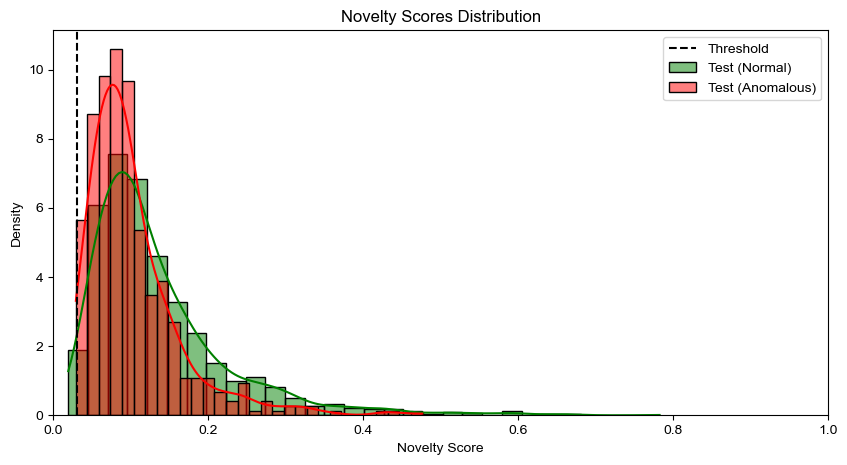


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.01      0.02      2000
           1       0.20      1.00      0.33       500

    accuracy                           0.21      2500
   macro avg       0.56      0.50      0.18      2500
weighted avg       0.78      0.21      0.09      2500

Optimal Threshold: 0.030665503814816475


In [11]:
# Evaluate and visualize
optimal_threshold = evaluate_and_visualize(model, test_loader, device)
print(f"Optimal Threshold: {optimal_threshold}")


In [12]:
import numpy as np
import torch
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

def evaluate_test_dataset(model, test_loader, threshold, device="cuda"):
    """
    설정된 임계값을 사용하여 test dataset에 대해 이상치를 판별하고 평가합니다.

    Args:
        model: GANomaly 모델 인스턴스
        test_loader: test sample을 포함한 DataLoader
        threshold (float): 이상치 판별을 위한 임계값
        device (str): 연산에 사용할 장치 (기본값: "cuda")
    """
    model.netg.eval()
    novelty_scores = []
    true_labels = []
    predictions = []

    with torch.no_grad():
        for data in test_loader:
            # 데이터 로드 및 device로 이동
            inputs, labels = data[0].to(device), data[1].to(device)
            if inputs.dim() == 3:
                inputs = inputs.unsqueeze(0)
            
            # latent 벡터 생성 및 novelty score 계산
            _, latent_i, latent_o = model.netg(inputs)
            scores = torch.mean((latent_i - latent_o) ** 2, dim=1)
            novelty_scores.extend(scores.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

            # 임계값을 사용해 이상 여부를 예측 (0: 정상, 1: 이상)
            pred = (scores >= threshold).int()
            predictions.extend(pred.cpu().numpy())

    # numpy 배열로 변환 및 차원 축소
    true_labels = np.array(true_labels).astype(int).flatten()
    predictions = np.array(predictions).astype(int).flatten()
    novelty_scores = np.array(novelty_scores).flatten()

    # Confusion matrix 생성 및 시각화
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks([0, 1], ["Normal", "Anomaly"])
    plt.yticks([0, 1], ["Normal", "Anomaly"])

    # 각 셀에 샘플 개수를 텍스트로 추가
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > cm.max() / 2 else "black")

    plt.show()

In [13]:
# 사용 예시: test_loader를 입력으로 전달하고 threshold 적용
evaluate_test_dataset(model, test_loader, optimal_threshold, device=device)

ValueError: too many values to unpack (expected 3)

---

In [ ]:
# Jupyter Notebook의 매개변수를 무시하도록 설정
sys.argv = ['']

# 옵션 설정
opt = Options().parse()
opt.isize = 256  # 데이터의 이미지 크기
opt.nc = 1       # 흑백 이미지이므로 채널 수를 1로 설정
opt.batchsize = 32  # 배치 크기 설정
opt.save_test_images = True  # 테스트 이미지 저장 설정
opt.display = True  # 실시간 시각화 설정
opt.niter = 50
opt.resume = {
    'netg_path': r"C:\Users\dhshs\Documents\ganomaly_global\project\output(use masking 가중치 0.5)\ganomaly\ELPV\train\weights\epoch50_netG.pth",
    'netd_path': r"C:\Users\dhshs\Documents\ganomaly_global\project\output(use masking 가중치 0.5)\ganomaly\ELPV\train\weights\epoch50_netD.pth"
}
opt.use_context_pred = True # 마스킹 설정

In [ ]:
dataloader = {'train': train_loader, 'test': test_loader}  # 데이터 로더 설정

# GANomaly 모델 생성
model = Ganomaly(opt, dataloader)